In [101]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import requests
from PIL import Image
from collections import Counter
import squarify
from tqdm import tqdm

import string

import re
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud ,STOPWORDS
import spacy
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
# from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

In [102]:
# pip install pycaret


In [103]:
# Load the spaCy English model
nlp = spacy.load("en_core_web_sm")
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore")


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [104]:
df=pd.read_csv("/kaggle/input/cyberbullying-dataset/twitter_parsed_dataset.csv")

In [105]:
df.head()

,index,id,Text,Annotation,oh_label
0,5.74948705591165E+017,5.74948705591165E+017,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0
1,5.71917888690393E+017,5.71917888690393E+017,@ShreyaBafna3 Now you idiots claim that people...,none,0.0
2,3.90255841338601E+017,3.90255841338601E+017,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0
3,5.68208850655916E+017,5.68208850655916E+017,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0
4,5.75596338802373E+017,5.75596338802373E+017,#mkr No No No No No No,none,0.0


In [106]:
df = df.drop(['id', 'index'], axis=1)
df.rename(columns={'oh_label': 'Label'}, inplace=True)
df = df.dropna(subset=['Label'])

In [107]:
def clean_tweet(tweet):
    # Remove URLs
    tweet = re.sub(r'http\S+', '', tweet)
    
    # Remove mentions and hashtags
    tweet = re.sub(r'@[A-Za-z0-9_]+|#[A-Za-z0-9_]+', '', tweet)
    
    # Remove special characters, numbers, and punctuation
    tweet = re.sub(r'[^A-Za-z\s]', '', tweet)
    
    # Remove 'RT' (Retweet) indicator
    tweet = re.sub(r'\bRT\b', '', tweet)
    
    # Convert to lowercase
    tweet = tweet.lower()
    
    # Remove stopwords
#     stop_words = set(stopwords.words('english'))
#     tweet_tokens = nltk.word_tokenize(tweet)
#     tweet = ' '.join([word for word in tweet_tokens if word not in stop_words])
    
    # Lemmatization
    doc = nlp(tweet)
    # Lemmatize each token and join them back into a string
    tweet = ' '.join([token.lemma_ for token in doc])
    
    return tweet

In [108]:
## Basic analysis of labels and annotations

print('Label distribution')
print(df.Label.value_counts())
print('-------------------------\n')
print('Annotation distribution')
print(df.Annotation.value_counts())
print('-------------------------\n')
print('Grouping of Annotation with label')
print(df.groupby('Annotation')['Label'].sum())

Label distribution
0.0    11501
1.0     5347
Name: Label, dtype: int64
-------------------------

Annotation distribution
none      11501
sexism     3377
racism     1970
Name: Annotation, dtype: int64
-------------------------

Grouping of Annotation with label
Annotation
none         0.0
racism    1970.0
sexism    3377.0
Name: Label, dtype: float64


In [109]:
def bully_palette(df,column, positions_to_change: list):
    """
    A function to create grey red palettes according to the inputs
    You just need to pass in the dataframe and the index of labels to be highlighted in red
    """
    palette = ['#96898b']*df[column].nunique()
    new_values = ['#cc253b']*len(positions_to_change)
    for position, new_value in zip(positions_to_change, new_values):
        palette[position] = new_value
    return sns.color_palette(palette)

In [110]:

def add_spines(colour = '#425169', linewidth = 2):
    """
    Add beautiful spines to you plots
    """
    ax = plt.gca()
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines[['bottom', 'left', 'top', 'right']].set_color(colour)
    ax.spines[['bottom', 'left', 'top', 'right']].set_linewidth(linewidth)

def roc_auc(predictions,target):
    '''
    This methods returns the AUC Score when given the Predictions
    and Labels
    '''
    
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc


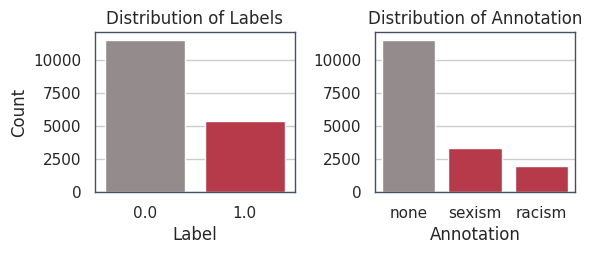

In [111]:
sns.set(style="whitegrid")
plt.figure(figsize=(6, 2))

plt.subplot(1, 2, 1)
# using the bully_pallete function to create a custom pallete
sns.countplot(x='Label', data=df, palette = bully_palette(df, 'Label', [1]))
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')
# adding spines using the helper function we declared earlier
add_spines(linewidth=1)

plt.subplot(1, 2, 2)
sns.countplot(x='Annotation', data=df, palette = bully_palette(df,'Annotation', [1, 2]))
plt.xlabel('Annotation')
plt.ylabel('')
plt.title('Distribution of Annotation')
add_spines(linewidth=1)

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.3)
plt.show()


In [112]:
def count_symbols(text):
    hashtag_count = len(re.findall(r'#', text))
    mention_count = len(re.findall(r'@', text))
    return hashtag_count, mention_count

# Apply the function to each row in the 'text' column
df[['num_hashtags', 'num_mentions']] = df['Text'].apply(lambda x: pd.Series(count_symbols(x)))

print('\nDataset shape: ', df.shape)
df.head()


Dataset shape:  (16848, 5)


,Text,Annotation,Label,num_hashtags,num_mentions
0,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0,0,3
1,@ShreyaBafna3 Now you idiots claim that people...,none,0.0,0,1
2,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0,0,1
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0,0,1
4,#mkr No No No No No No,none,0.0,1,0


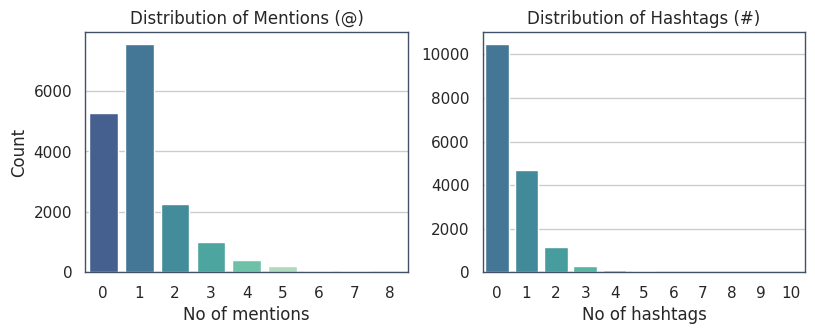

In [113]:
plt.figure(figsize=(9, 3))

plt.subplot(1, 2, 1)
sns.countplot(x='num_mentions', data=df, palette =  sns.color_palette("mako", n_colors=9)[3:])
plt.xlabel('No of mentions')
plt.ylabel('Count')
plt.title('Distribution of Mentions (@)')
add_spines(linewidth=1)

plt.subplot(1, 2, 2)
sns.countplot(x='num_hashtags', data=df, palette = sns.color_palette("mako", n_colors=11)[5:])
plt.xlabel('No of hashtags')
plt.ylabel('')
plt.title('Distribution of Hashtags (#)')
add_spines(linewidth=1)

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.23, hspace=0.3)
plt.show()

<Figure size 600x300 with 0 Axes>

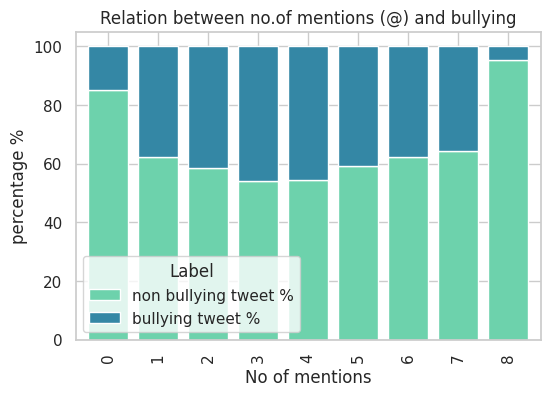

In [114]:
plt.figure(figsize=(6, 3))
mention_label_cross = pd.crosstab(df['num_mentions'], df['Label'])
mention_label_cross['sum'] = mention_label_cross[0.0] + mention_label_cross[1.0]
mention_label_cross['non bullying tweet %'] = mention_label_cross[0.0]/mention_label_cross['sum']*100
mention_label_cross['bullying tweet %'] = mention_label_cross[1.0]/mention_label_cross['sum']*100
mention_label_cross = mention_label_cross.drop([0.0, 1.0, 'sum'], axis=1)

mention_label_cross.plot(kind='bar', stacked=True, figsize=(6, 4), color=['#6dd2ac', '#3487a5'], width=0.8)
plt.xlabel('No of mentions')
plt.ylabel('percentage %')
plt.title('Relation between no.of mentions (@) and bullying')
plt.show()

In [115]:
## Extraction of the top ten mentions and hashtags in the dataset

# Function to extract hashtags from a text
def extract_hashtags(text):
    return re.findall(r'#\w+', text)

df['Hashtags'] = df['Text'].apply(extract_hashtags)

# Function to extract hashtags from a text
def extract_mentions(text):
    return re.findall(r'@\w+', text)

df['Mentions'] = df['Text'].apply(extract_mentions)

def create_counter_df(df):
    """
    Creates a dataframe that contains the Label and their count.
    Pass the dataframe containing the labels in the form of a list column as an input.
    Example usage:
    1. mentions = create_counter_df(df['Mentions'])
    2. sexist_mentions = create_counter_df(df[df.Annotation=='sexist']["Mentions"])
    """
    # Flatten the list of hashtags and count their occurrences
    all_counts = [tag for counts_list in df for tag in counts_list]
    label_counts = Counter(all_counts)

    # Create a DataFrame from the Counter dictionary
    counts_df = pd.DataFrame(list(label_counts.items()), columns=['Label', 'Count'])
    counts_df = counts_df.sort_values(by='Count', ascending=False)
    return counts_df
    
mentions_df = create_counter_df(df['Mentions'])
top_10_mentions = mentions_df.head(10)
sexist_mentions = create_counter_df(df[df.Annotation=='sexism']["Mentions"])
top_10_sexist_mentions = sexist_mentions.head(10)
racist_mentions = create_counter_df(df[df.Annotation=='racism']["Mentions"])
top_10_racist_mentions = racist_mentions.head(10)

hashtags_df = create_counter_df(df['Hashtags'])
top_10_hashtags = hashtags_df.head(10)
sexist_hashtags = create_counter_df(df[df.Annotation=='sexism']["Hashtags"])
top_10_sexist_hashtags = sexist_hashtags.head(10)
racist_hashtags = create_counter_df(df[df.Annotation=='racism']["Hashtags"])
top_10_racist_hashtags = racist_hashtags.head(10)

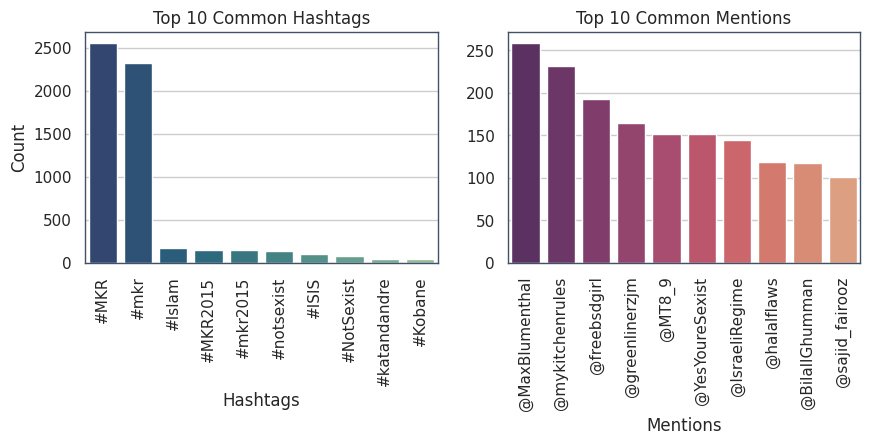

In [116]:
plt.figure(figsize=(10, 3))

plt.subplot(121)
sns.barplot(x='Label', y='Count', data=top_10_hashtags, palette='crest_r')
plt.title('Top 10 Common Hashtags')
plt.xlabel('Hashtags')
plt.ylabel('Count')
plt.xticks(rotation=90)
add_spines(linewidth=1)

plt.subplot(122)
sns.barplot(x='Label', y='Count', data=top_10_mentions, palette='flare_r')
plt.title('Top 10 Common Mentions')
plt.xlabel('Mentions')
plt.ylabel('')
plt.xticks(rotation=90)
add_spines(linewidth=1)

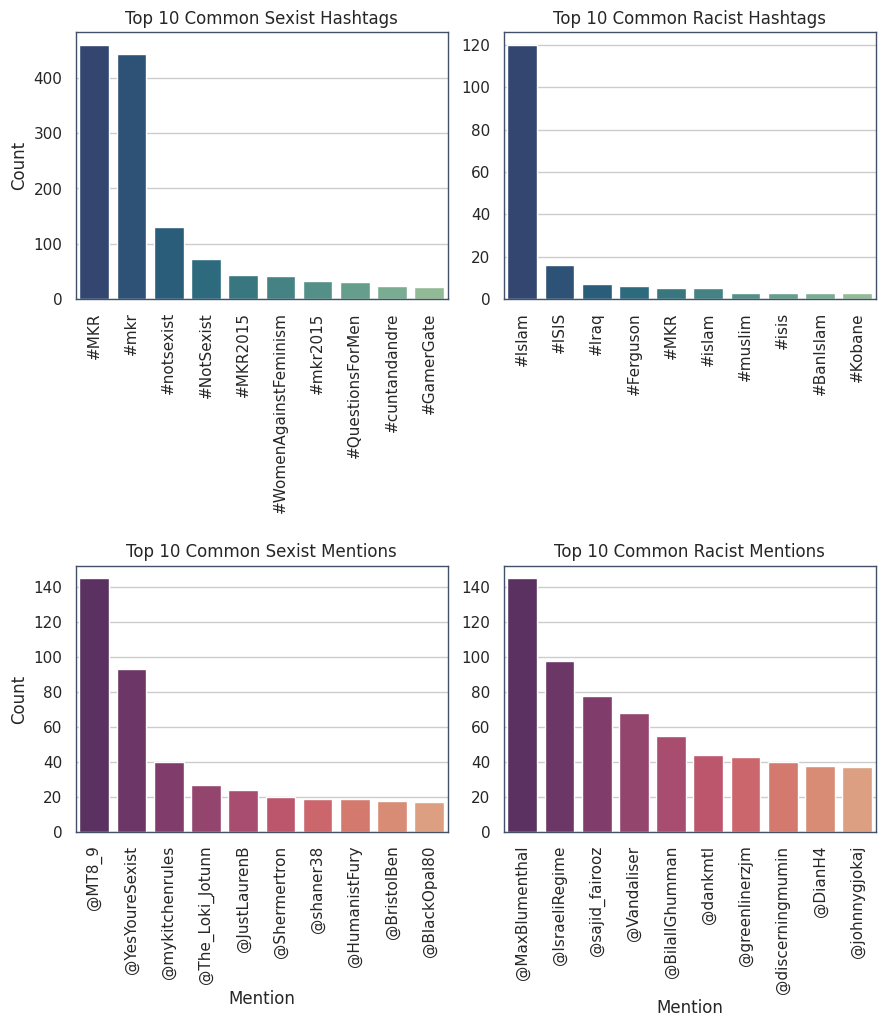

In [117]:
plt.figure(figsize=(10, 10))

plt.subplot(221)
sns.barplot(x='Label', y='Count', data=top_10_sexist_hashtags, palette='crest_r')
plt.title('Top 10 Common Sexist Hashtags')
plt.xlabel('')
plt.ylabel('Count')

plt.xticks(rotation=90)
add_spines(linewidth=1)

plt.subplot(222)
sns.barplot(x='Label', y='Count', data=top_10_racist_hashtags, palette='crest_r')
plt.title('Top 10 Common Racist Hashtags')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=90)
add_spines(linewidth=1)

plt.subplot(223)
sns.barplot(x='Label', y='Count', data=top_10_sexist_mentions, palette='flare_r')
plt.title('Top 10 Common Sexist Mentions')
plt.xlabel('Mention')
plt.ylabel('Count')
plt.xticks(rotation=90)
add_spines(linewidth=1)

plt.subplot(224)
sns.barplot(x='Label', y='Count', data=top_10_racist_mentions, palette='flare_r')
plt.title('Top 10 Common Racist Mentions')
plt.xlabel('Mention')
plt.ylabel('')
plt.xticks(rotation=90)
add_spines(linewidth=1)

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.15, hspace=1)
plt.show()

In [118]:
df['Text'] = df['Text'].apply(clean_tweet)
df.head()

,Text,Annotation,Label,num_hashtags,num_mentions,Hashtags,Mentions
0,I read they in contextno change in mean th...,none,0.0,0,3,[],"[@halalflaws, @biebervalue, @greenlinerzjm]"
1,now you idiot claim that people who try to s...,none,0.0,0,1,[],[@ShreyaBafna3]
2,call I sexist but when I go to an auto plac...,sexism,1.0,0,1,[],[@Mooseoftorment]
3,wrong isis follow the example of mohammed an...,racism,1.0,0,1,[],[@g0ssipsquirrelx]
4,no no no no no no,none,0.0,1,0,[#mkr],[]


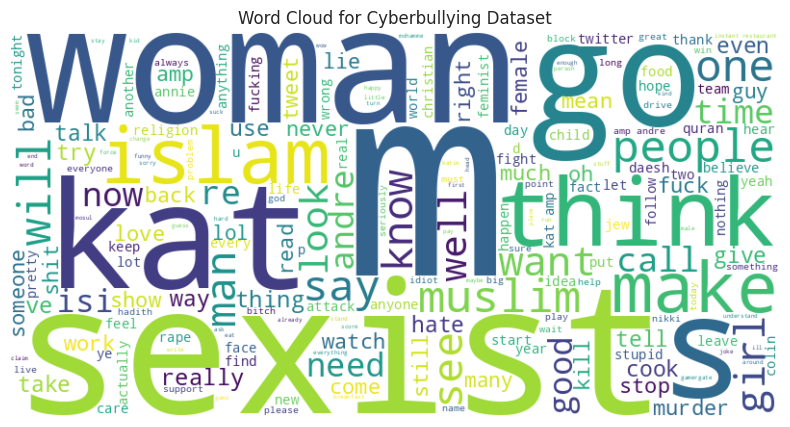

In [119]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming your data is in a DataFrame named 'df'
# If not, load your data into a DataFrame first

# Extract text data from the 'Text' column
text_data = df['Text'].str.cat(sep=' ')

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

# Plot the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis labels
plt.title('Word Cloud for Cyberbullying Dataset')
plt.show()


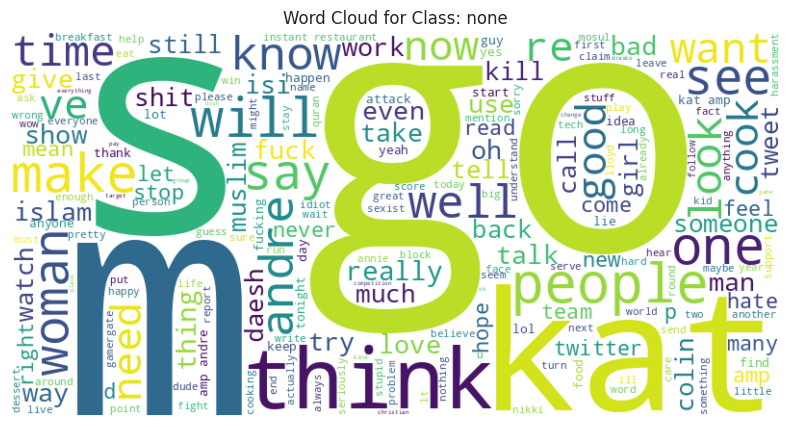

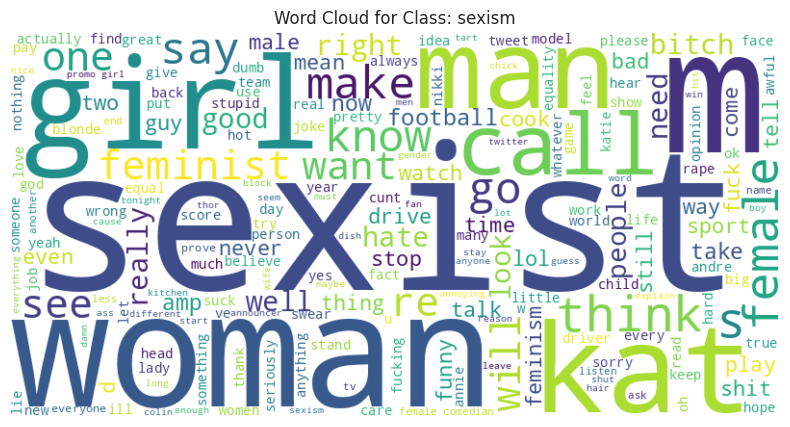

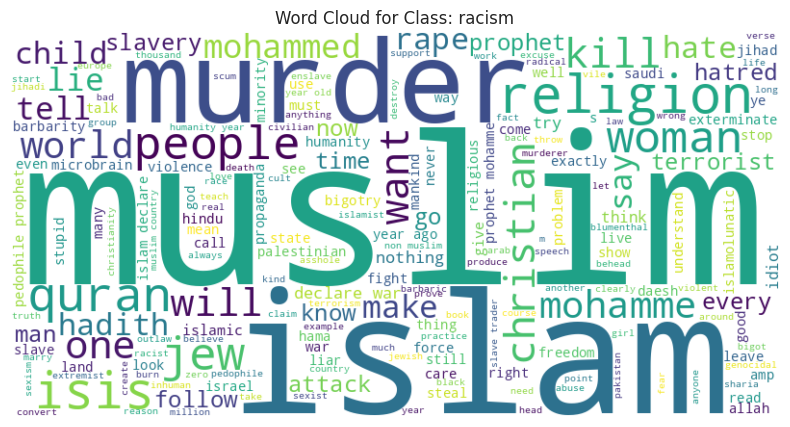

In [178]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming your data is in a DataFrame named 'df'
# If not, load your data into a DataFrame first

# Filter data for each class
class_data = {}
for label in df['Annotation'].unique():
    class_data[label] = df[df['Annotation'] == label]['Text'].str.cat(sep=' ')

# Create a separate word cloud for each class
for label, text_data in class_data.items():
    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

    # Plot the WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off axis labels
    plt.title(f'Word Cloud for Class: {label}')
    plt.show()


In [121]:
X = df['Text'].values.reshape(-1, 1)
y = df['Label'].values

In [122]:
print(X)

[['    I read they in contextno change in mean the history of islamic slavery']
 ['  now you idiot claim that people who try to stop he from become a terrorist make he a terrorist islamically brain dead']
 ['   call I sexist but when I go to an auto place i d rather talk to a guy']
 ...
 ['   deconstruct lemon tartcan we please go just one season of   without someone call something deconstruct']
 ['    you be too stupid to talk to block']
 ['and before you protest that you re not mad there s not much other reason you d be out tweet at woman about feminism']]


In [123]:
# convert text (object) data to string for w2v
X_resampled= [str(obj) for obj in X]
X_resampled = np.array(X_resampled)

In [ ]:
# Train Word2Vec Model
sentences = [word_tokenize(text) for text in X_resampled]
word2vec_model = Word2Vec(sentences, vector_size=300, window=5, min_count=1, workers=4)  # Adjust parameters as needed

# Convert Text to Embeddings
def get_embedding(text):
    tokens = word_tokenize(text)
    # Filter out tokens that are not in the vocabulary
    tokens = [token for token in tokens if token in word2vec_model.wv.key_to_index]
    if len(tokens) > 0:
        # Return the average of word embeddings for the tokens
        return np.mean([word2vec_model.wv[t] for t in tokens], axis=0)
    else:
        return None

# Create an array of embeddings for each text
X_resampled = [get_embedding(text) for text in X_resampled]

In [ ]:
print(len(X_resampled))

In [ ]:
print(len(X_resampled[0]))

In [125]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip
!ls -lat

--2024-04-12 15:44:24--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-04-12 15:44:25--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-04-12 15:44:25--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: 'glove.6B.zip.6'

gl

In [127]:
filepath="/kaggle/working/glove.6B.50d.txt"


In [128]:
import torch
from torch.nn.utils.rnn import pad_sequence
from torchtext.data.utils import get_tokenizer


In [129]:

# Define the tokenizer (using spaCy tokenizer as an example)
tokenizer = get_tokenizer('spacy', language='en_core_web_lg')


# Build vocabulary from the example sentences
vocab = {}
for sentence in X:
    tokens = tokenizer(str(sentence))
    for token in tokens:
        if token not in vocab:
            vocab[token] = len(vocab) + 1  # Assign a unique index to each token

# Tokenize each sentence and convert tokens to vectors (replace <pad> with 0)
max_len = 40  # Maximum length for padding
tokenized_sentences = [torch.tensor([vocab.get(token, 0) for token in tokenizer(str(sentence))] + [0] * (max_len - len(tokenizer(str(sentence)))))
                       for sentence in X]

# Pad sequences to the same length
padded_sentences = pad_sequence(tokenized_sentences, batch_first=True)

print("Tokenized and padded sentences:")
print(padded_sentences)
print("Shape:", padded_sentences.shape)
print("Vocabulary size:", len(vocab))


Tokenized and padded sentences:
tensor([[ 1,  2,  3,  ...,  0,  0,  0],
        [ 1,  2, 17,  ...,  0,  0,  0],
        [ 1,  2, 37,  ...,  0,  0,  0],
        ...,
        [ 1,  2, 37,  ...,  0,  0,  0],
        [ 1,  2,  3,  ...,  0,  0,  0],
        [ 1,  2, 56,  ...,  0,  0,  0]])
Shape: torch.Size([16848, 47])
Vocabulary size: 12694


In [130]:
print(len(padded_sentences[0]))

47


In [131]:

embeddings_index = {}
f = open('/kaggle/working/glove.6B.300d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

400000it [00:44, 8961.48it/s]

Found 400000 word vectors.


In [132]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(vocab)+ 1, 300))
for word, i in tqdm(vocab.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 12694/12694 [00:00<00:00, 231339.24it/s]


In [133]:
print(embedding_matrix.shape)

(12695, 300)


In [134]:
print(X[0])

['    I read they in contextno change in mean the history of islamic slavery']


In [160]:
import fasttext


# Flatten the list of lists into a list of strings
flattened_sentences = [' '.join(sentence) for sentence in X]

# Save sentences to a text file (required for training with fastText)
with open('X.txt', 'w') as f:
    for sentence in flattened_sentences:
        f.write(sentence + '\n')

In [ ]:
print(flattened_sentences[0])

In [ ]:
# Train a FastText model
model = fasttext.train_unsupervised('X.txt', model='skipgram')

# Get word embeddings for each word in the dataset
word_embeddings = {}
for word in model.words:
    word_embeddings[word] = model[word]

# Example usage to get the embedding for a specific word
print("Embedding for 'example':", word_embeddings['mother'])

In [135]:

# Example usage
batch_size = 32
hidden_dim = 128
lstm_layers = 2
embedding_dim = 300  # Assuming FastText embeddings with 300 dimensions



In [ ]:
print(X.shape)

In [ ]:
print(y.shape)

In [ ]:
X1=df['Text']

In [ ]:
print(X1.shape)

In [ ]:
print(y[0])

In [ ]:
print(df.head())

In [ ]:
print(df['Label'][1])

In [136]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
# # Initialize LabelEncoder
# label_encoder = LabelEncoder()

# # Fit and transform the "Annotation" column
# df['Annotation_Encoded'] = label_encoder.fit_transform(df['Annotation'])

# # Display the DataFrame with encoded labels
# print(df.head())

In [ ]:
print(y)

In [137]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset


In [138]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(padded_sentences, y, test_size=0.2, random_state=42)


In [139]:

# Convert X_train and y_train to tensors if they are not already
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

# Create DataLoader for training data
batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [140]:
import torch
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embedding_matrix, max_len):
        super(LSTMClassifier, self).__init__()
        
        # Embedding layer with pretrained embeddings
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False  # Freeze the embedding layer
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True)
        
        # Dense layer
        self.fc = nn.Linear(hidden_dim, 1)
        
        # Sigmoid activation for binary classification
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        # Extract the output of the last time step
        lstm_last = lstm_out[:, -1, :]
        output = self.fc(lstm_last)
        output = self.sigmoid(output)
        return output

# Define hyperparameters and create the model
vocab_size = (len(vocab))+ 1
embedding_dim = 300
hidden_dim = 100
max_len = max_len  # Assuming max_len is defined
# embedding_matrix = your_embedding_matrix  # Replace with your actual embedding matrix

model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, embedding_matrix, max_len)
criterion = nn.BCELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [141]:
import matplotlib.pyplot as plt

# Initialize lists to store losses and epochs
train_losses = []
epochs = []

num_epochs = 10  # Adjust as needed
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0.0
    
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()  # Zero the gradients
        batch_x = batch_x.long()  # Convert input to LongTensor
        batch_y = batch_y.float()  # Convert to float tensor if not already
        batch_y = batch_y.view(-1)  # Reshape to match the size of output
        output = model(batch_x)
        loss = criterion(output.squeeze(), batch_y)  # Calculate the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        
        total_loss += loss.item() * batch_x.size(0)  # Accumulate total loss
    
    avg_loss = total_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')
    
    # Save the average loss and epoch number
    train_losses.append(avg_loss)
    epochs.append(epoch + 1)




Epoch 1/10, Loss: 0.5420
Epoch 2/10, Loss: 0.4440
Epoch 3/10, Loss: 0.4185
Epoch 4/10, Loss: 0.4049
Epoch 5/10, Loss: 0.3783
Epoch 6/10, Loss: 0.3559
Epoch 7/10, Loss: 0.3339
Epoch 8/10, Loss: 0.3067
Epoch 9/10, Loss: 0.2662
Epoch 10/10, Loss: 0.2392


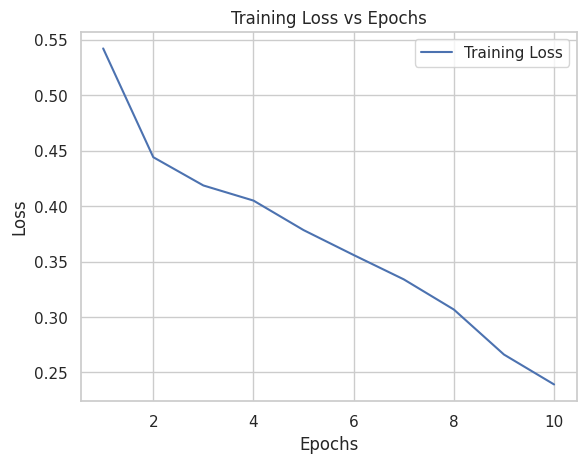

In [142]:
# Plot the training loss versus epochs
plt.plot(epochs, train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs Epochs')
plt.legend()
plt.show()

In [143]:
# Convert X_train and y_train to tensors if they are not already
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

In [144]:
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [145]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Assuming val_loader is your DataLoader for validation data
with torch.no_grad():
    val_losses = []
    val_accuracy = []
    val_loss = 0.0
    correct_preds = 0
    total_preds = 0
    
    for batch_x, batch_y in val_loader:
        # Convert batch_x to LongTensor before passing it through the model
        batch_x = batch_x.long()
        
        output = model(batch_x)
        batch_y = batch_y.float()  # Convert to float tensor if not already
        batch_y = batch_y.view(-1)  # Reshape to match the size of output
        
        # Assuming batch_y is initially of size [batch_size, 1]
        batch_loss = criterion(output.squeeze(), batch_y).item()
        val_loss += batch_loss * batch_x.size(0)
        val_losses.append(batch_loss)
        
        # Compute accuracy
        predicted_labels = (output > 0.5).float()  # Threshold at 0.5 for binary classification
        correct_preds += (predicted_labels == batch_y.float().unsqueeze(-1)).sum().item()
        total_preds += batch_x.size(0)
    
    # Calculate validation metrics
    avg_val_loss = val_loss / len(val_loader.dataset)
    accuracy = correct_preds / total_preds
    val_accuracy.append(accuracy)



print(f'Average Validation Loss: {avg_val_loss:.4f}, Average Validation Accuracy: {accuracy:.4f}')


Average Validation Loss: 0.5025, Average Validation Accuracy: 0.8139


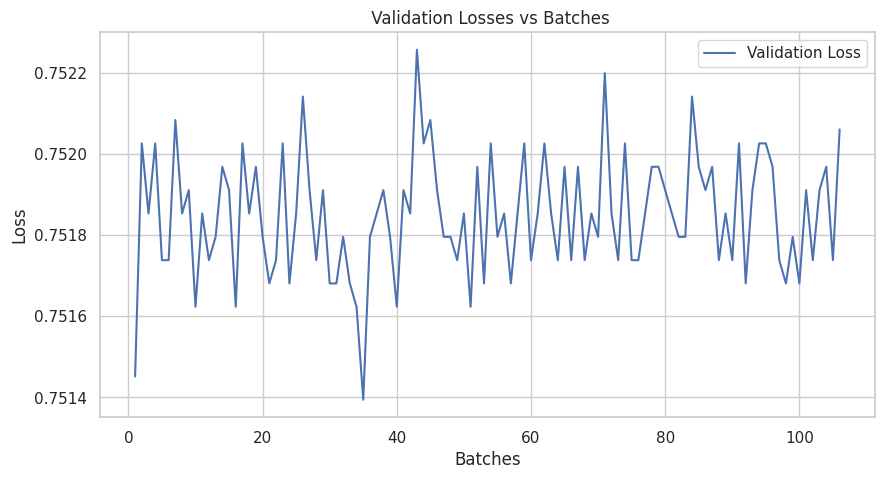

In [186]:
# Plot both training and validation losses
plt.figure(figsize=(10, 5))

plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.title(' Validation Losses vs Batches')
plt.legend()
plt.show()

In [ ]:
print(type(embedding_matrix))

In [ ]:
print(type(X_resampled))

Epoch 1/10, Loss: 0.7106
Epoch 2/10, Loss: 0.7106
Epoch 3/10, Loss: 0.7177
Epoch 4/10, Loss: 0.7378
Epoch 5/10, Loss: 0.7938
Epoch 6/10, Loss: 0.7723
Epoch 7/10, Loss: 0.7614
Epoch 8/10, Loss: 0.7555
Epoch 9/10, Loss: 0.7536
Epoch 10/10, Loss: 0.7524


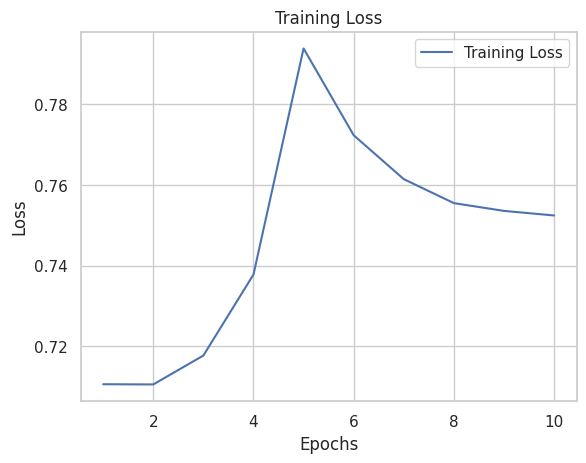

In [179]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, logits, targets):
        bce_loss = nn.BCEWithLogitsLoss(reduction='none')(logits, targets)  # Binary Cross Entropy with Logits
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        return torch.mean(focal_loss)

# Custom loss function incorporating Focal Loss
class CustomLossWithFocal(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super(CustomLossWithFocal, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce_loss = nn.BCEWithLogitsLoss(reduction='mean')

    def forward(self, logits, targets, model):
        # Calculate BCE loss
        bce_loss = self.bce_loss(logits, targets)

        # Calculate Focal loss
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss

        # Add regularization term if needed
        regularization_loss = 0.0
        for param in model.parameters():
            regularization_loss += torch.norm(param)
        
        # Combine Focal loss and regularization
        total_loss = focal_loss + regularization_loss 

        return total_loss

# Initialize your model, optimizer, and other necessary components
model1 = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, embedding_matrix, max_len)
optimizer = optim.Adam(model1.parameters(), lr=0.01)
criterion = CustomLossWithFocal(alpha=0.25, gamma=2)  # Using CustomLossWithFocal

# Initialize lists to store losses and epochs
train_losses = []
epochs = []

num_epochs = 10  # Adjust as needed
for epoch in range(num_epochs):
    model1.train()  # Set the model to training mode
    total_loss = 0.0
    
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()  # Zero the gradients
        batch_x = batch_x.long()  # Convert input to LongTensor
        batch_y = batch_y.float()  # Convert to float tensor if not already
        batch_y = batch_y.view(-1)  # Reshape to match the size of output
        output = model1(batch_x)
        loss = criterion(output.squeeze(), batch_y, model1)  # Custom loss calculation
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        
        total_loss += loss.item() * batch_x.size(0)  # Accumulate total loss
    
    avg_loss = total_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')
    
    # Save the average loss and epoch number
    train_losses.append(avg_loss)
    epochs.append(epoch + 1)

# Plot the training loss
plt.plot(epochs, train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


In [180]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Assuming val_loader is your DataLoader for validation data
with torch.no_grad():
    val_losses = []
    val_accuracy = []
    val_loss = 0.0
    correct_preds = 0
    total_preds = 0
    
    for batch_x, batch_y in val_loader:
        # Convert batch_x to LongTensor before passing it through the model
        batch_x = batch_x.long()
        
        output = model1(batch_x)
        batch_y = batch_y.float()  # Convert to float tensor if not already
        batch_y = batch_y.view(-1)  # Reshape to match the size of output
        
        # Assuming batch_y is initially of size [batch_size, 1]
        batch_loss =  criterion(output.squeeze(), batch_y, model1).item()
        val_loss += batch_loss * batch_x.size(0)
        val_losses.append(batch_loss)
        
        # Compute accuracy
        predicted_labels = (output > 0.5).float()  # Threshold at 0.5 for binary classification
        correct_preds += (predicted_labels == batch_y.float().unsqueeze(-1)).sum().item()
        total_preds += batch_x.size(0)
    
    # Calculate validation metrics
    avg_val_loss = val_loss / len(val_loader.dataset)
    accuracy = correct_preds / total_preds
    val_accuracy.append(accuracy)



print(f'Average Validation Loss: {avg_val_loss:.4f}, Average Validation Accuracy: {accuracy:.4f}')


Average Validation Loss: 0.7518, Average Validation Accuracy: 0.6843
